# Quick Uninstall Analysis

This notebook analyzes users who uninstalled the extension very quickly (within 5 minutes of installation).

In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set style for plots
plt.style.use('ggplot')
sns.set(style='whitegrid')

colors = ['#E0F26D', 'salmon', '#73FABD', '#6ED1F8','#F899F3', '#106ED3']
faceColor = '#F5F5F5'

In [396]:
# Load the data
df = pd.read_csv('analytics.csv')

# Display basic information about the dataset
print(f"Total number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
df.head()

Total number of records: 8520
Columns: ['id', 'type', 'url', 'payload', 'user_id', 'session_id', 'received_at', 'created_at', 'domain']

Data types:
id              int64
type           object
url            object
payload        object
user_id        object
session_id     object
received_at    object
created_at     object
domain         object
dtype: object


,id,type,url,payload,user_id,session_id,received_at,created_at,domain
0,19636,on-onboarding,www.lessextension.com/onboarding,"""""",none,none,2025-03-27T15:23:55.135162+00:00,2025-03-27T15:23:51.868+00:00,lessextension.com
1,19648,time-spent,www.ticketmaster.dk/checkout/Z698xZC4Z1744-y/5...,"{""duration"":4717}",0b7cd927-52ef-434b-8b2e-9c63281c6327,8edc93bd-6b53-402b-be22-a038953822c8,2025-03-27T15:28:02.023488+00:00,2025-03-27T15:28:01.461+00:00,ticketmaster.dk
2,19649,time-spent,www.ticketmaster.dk/checkout/Z698xZC4Z1744-y/5...,"{""duration"":4881}",0b7cd927-52ef-434b-8b2e-9c63281c6327,8edc93bd-6b53-402b-be22-a038953822c8,2025-03-27T15:28:06.25507+00:00,2025-03-27T15:28:05.707+00:00,ticketmaster.dk
3,19650,time-spent,www.ticketmaster.dk/checkout/Z698xZC4Z1744-y/5...,"{""duration"":5000}",0b7cd927-52ef-434b-8b2e-9c63281c6327,8edc93bd-6b53-402b-be22-a038953822c8,2025-03-27T15:28:11.192089+00:00,2025-03-27T15:28:10.706+00:00,ticketmaster.dk
4,19651,time-spent,www.ticketmaster.dk/checkout/Z698xZC4Z1744-y/5...,"{""duration"":5000}",0b7cd927-52ef-434b-8b2e-9c63281c6327,8edc93bd-6b53-402b-be22-a038953822c8,2025-03-27T15:28:16.280017+00:00,2025-03-27T15:28:15.704+00:00,ticketmaster.dk


In [397]:
# Convert timestamp columns to datetime
df['received_at'] = pd.to_datetime(df['received_at'])
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)

# Count event types
event_counts = df['type'].value_counts()
print("Event type distribution:")
event_counts

Event type distribution:


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_99359/333821806.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)


type
time-spent                    7195
page-view                      742
from-directs                   213
on-onboarding                  174
from-directs-cta                42
add-to-cart                     36
uninstall                       27
open-popup                      25
welcome-modal-seen              17
active                          15
enforce_wait_modal_shown        14
enforce_wait_info_expanded       7
enforce_wait_canceled            6
questionary-popup                4
open-options                     3
Name: count, dtype: int64

In [398]:
# Identify onboarding and uninstall events
onboarding_events = df[df['type'] == 'on-onboarding'].copy()
uninstall_events = df[df['type'] == 'uninstall'].copy()

print(f"Total onboarding events: {len(onboarding_events)}")
print(f"Total uninstall events: {len(uninstall_events)}")

Total onboarding events: 174
Total uninstall events: 27


In [399]:
# Focus on users who have user_id values (not 'none')
valid_onboarding = onboarding_events[onboarding_events['user_id'] != 'none'].copy()
valid_uninstalls = uninstall_events[uninstall_events['user_id'] != 'none'].copy()

print(f"Valid onboarding events: {len(valid_onboarding)}")
print(f"Valid uninstall events: {len(valid_uninstalls)}")

Valid onboarding events: 0
Valid uninstall events: 27


In [400]:
# Create a dictionary of users with their first onboarding time
user_first_onboarding = {}
for _, row in valid_onboarding.iterrows():
    user_id = row['user_id']
    time = row['created_at']
    if user_id not in user_first_onboarding or time < user_first_onboarding[user_id]:
        user_first_onboarding[user_id] = time

# In case we don't have explicit onboarding events for some users,
# let's also check the first activity of any kind
user_first_activity = {}
for _, row in df[df['user_id'] != 'none'].iterrows():
    user_id = row['user_id']
    time = row['created_at']
    if user_id not in user_first_activity or time < user_first_activity[user_id]:
        user_first_activity[user_id] = time

# For each user, get their installation time (either from onboarding or first activity)
user_install_time = {}
for user_id in user_first_activity.keys():
    if user_id in user_first_onboarding:
        user_install_time[user_id] = user_first_onboarding[user_id]
    else:
        user_install_time[user_id] = user_first_activity[user_id]

print(f"Total users with identified installation time: {len(user_install_time)}")

Total users with identified installation time: 54


In [401]:
# Calculate the time to uninstall for each user
uninstall_times = []

for _, row in valid_uninstalls.iterrows():
    user_id = row['user_id']
    uninstall_time = row['created_at']
    
    if user_id in user_install_time:
        install_time = user_install_time[user_id]
        time_diff = (uninstall_time - install_time).total_seconds() / 60  # Convert to minutes
        
        uninstall_times.append({
            'user_id': user_id,
            'install_time': install_time,
            'uninstall_time': uninstall_time,
            'minutes_to_uninstall': time_diff
        })

# Convert to DataFrame
uninstall_df = pd.DataFrame(uninstall_times)

# Sort by time to uninstall
if not uninstall_df.empty:
    uninstall_df = uninstall_df.sort_values('minutes_to_uninstall')
    
    print(f"Total users with calculated uninstall time: {len(uninstall_df)}")
    uninstall_df.head(10)

Total users with calculated uninstall time: 27


In [402]:
# Identify users who uninstalled within 5 minutes
if not uninstall_df.empty:
    quick_uninstalls = uninstall_df[uninstall_df['minutes_to_uninstall'] <= 5]
    
    print(f"Number of users who uninstalled within 5 minutes: {len(quick_uninstalls)}")
    print(f"Percentage of all uninstalls: {len(quick_uninstalls) / len(uninstall_df) * 100:.2f}%")
    
    quick_uninstalls.head(10)

Number of users who uninstalled within 5 minutes: 21
Percentage of all uninstalls: 77.78%


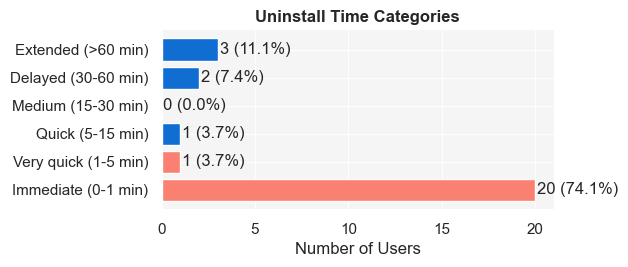

In [403]:
# # Visualize uninstall time distribution
# if not uninstall_df.empty:
#     plt.figure(figsize=(12, 10))
    
#     # Plot 1: Histogram of uninstall times (within 60 minutes)
#     plt.subplot(2, 1, 1)
#     sns.histplot(uninstall_df[uninstall_df['minutes_to_uninstall'] <= 60]['minutes_to_uninstall'], 
#                 bins=20, kde=False, color=colors[5])
    
#     plt.axvline(x=5, color=colors[1], linestyle='--', label='5-minute mark')
    
#     # Make grid lines white and remove the border
#     plt.grid(color='white', linestyle='-', linewidth=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['left'].set_visible(False)
#     plt.gca().spines['bottom'].set_visible(False)
    
#     # Set background color
#     plt.gca().set_facecolor(faceColor)
    
#     # Make the title bold
#     plt.title('Distribution of Quick Uninstalls (within 1 hour)', fontweight='bold')
    
#     # Update x-axis ticks with even minute markers
#     plt.xticks(range(0, 65, 5))
    
#     plt.xlabel('Minutes until uninstall')
#     plt.ylabel('Count')
#     plt.legend()
    
    # Plot 2: Alternative visualization - Time-to-uninstall categories
plt.subplot(2, 1, 2)
    
# Define time categories
categories = [
    'Immediate (0-1 min)',
    'Very quick (1-5 min)',
    'Quick (5-15 min)', 
    'Medium (15-30 min)',
    'Delayed (30-60 min)',
    'Extended (>60 min)'
]

# Count users in each category
immediate = len(uninstall_df[uninstall_df['minutes_to_uninstall'] <= 1])
very_quick = len(uninstall_df[(uninstall_df['minutes_to_uninstall'] > 1) & 
                                (uninstall_df['minutes_to_uninstall'] <= 5)])
quick = len(uninstall_df[(uninstall_df['minutes_to_uninstall'] > 5) & 
                            (uninstall_df['minutes_to_uninstall'] <= 15)])
medium = len(uninstall_df[(uninstall_df['minutes_to_uninstall'] > 15) & 
                            (uninstall_df['minutes_to_uninstall'] <= 30)])
delayed = len(uninstall_df[(uninstall_df['minutes_to_uninstall'] > 30) & 
                            (uninstall_df['minutes_to_uninstall'] <= 60)])
extended = len(uninstall_df[uninstall_df['minutes_to_uninstall'] > 60])

counts = [immediate, very_quick, quick, medium, delayed, extended]

# Calculate percentages
total = len(uninstall_df)
percentages = [count/total*100 for count in counts]

# Create horizontal bar chart with gradient colors
gradient_colors = [colors[1], colors[1], colors[5], colors[5], colors[5], colors[5]]

bars = plt.barh(categories, counts, color=gradient_colors)

# Add count and percentage labels
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    plt.text(count + 0.1, i, f"{count} ({percentage:.1f}%)", va='center')

# Customize appearance
plt.title('Uninstall Time Categories', fontweight='bold')
plt.xlabel('Number of Users')
plt.grid(color='white', linestyle='-', linewidth=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_facecolor(faceColor)

# Add summary annotation
quick_uninstall_pct = (immediate + very_quick) / total * 100

plt.tight_layout()
plt.show()

# PART 2: Analyzing Session Counts and Time Spent Before Uninstall

In [404]:
# Identify users who uninstalled quickly for further analysis
if not uninstall_df.empty:
    # We'll focus on users who uninstalled within 5 minutes
    quick_uninstallers = uninstall_df[uninstall_df['minutes_to_uninstall'] <= 5]['user_id'].unique()
    other_uninstallers = uninstall_df[uninstall_df['minutes_to_uninstall'] > 5]['user_id'].unique()
    
    print(f"Number of users who uninstalled within 5 minutes: {len(quick_uninstallers)}")
    print(f"Number of users who uninstalled after 5 minutes: {len(other_uninstallers)}")

Number of users who uninstalled within 5 minutes: 21
Number of users who uninstalled after 5 minutes: 6


In [405]:
# Function to count sessions per user
def count_sessions_per_user(user_id, df):
    """Count the number of unique sessions for a given user"""
    # Filter data for this user
    user_data = df[df['user_id'] == user_id]
    # Count unique session_ids (excluding 'none')
    unique_sessions = user_data[user_data['session_id'] != 'none']['session_id'].nunique()
    return unique_sessions

# Analyze session counts for quick uninstallers vs other uninstallers
if not uninstall_df.empty:
    # Get session counts for quick uninstallers
    quick_session_counts = [count_sessions_per_user(user_id, df) for user_id in quick_uninstallers]
    
    # Get session counts for other uninstallers
    other_session_counts = [count_sessions_per_user(user_id, df) for user_id in other_uninstallers]
    
    # Print summary statistics
    print("\nSession Count Analysis:")
    print(f"Quick uninstallers (≤5 min):")
    print(f"  Average sessions: {np.mean(quick_session_counts):.2f}")
    print(f"  Median sessions: {np.median(quick_session_counts):.2f}")
    print(f"  Max sessions: {np.max(quick_session_counts)}")
    print(f"  Min sessions: {np.min(quick_session_counts)}")
    
    print(f"\nOther uninstallers (>5 min):")
    print(f"  Average sessions: {np.mean(other_session_counts):.2f}")
    print(f"  Median sessions: {np.median(other_session_counts):.2f}")
    print(f"  Max sessions: {np.max(other_session_counts)}")
    print(f"  Min sessions: {np.min(other_session_counts)}")


Session Count Analysis:
Quick uninstallers (≤5 min):
  Average sessions: 0.10
  Median sessions: 0.00
  Max sessions: 1
  Min sessions: 0

Other uninstallers (>5 min):
  Average sessions: 8.33
  Median sessions: 6.00
  Max sessions: 20
  Min sessions: 2


In [406]:
# Analyze time spent on websites before uninstall
# Calculate total time spent for each user
def get_user_time_spent(user_id, df):
    """Calculate total time spent on websites for a user based on time-spent events"""
    # Filter data for this user and time-spent events
    user_time_events = df[(df['user_id'] == user_id) & (df['type'] == 'time-spent')]
    
    total_time = 0
    for _, row in user_time_events.iterrows():
        try:
            # Parse the duration from the payload JSON
            if pd.notna(row['payload']):
                payload = eval(row['payload'].replace('null', 'None'))
                if 'duration' in payload:
                    # Convert milliseconds to seconds
                    total_time += int(payload['duration']) / 1000
        except:
            # Skip if there's an error parsing the payload
            continue
    
    # Return time in seconds
    return total_time

# Calculate average time per session
def get_avg_time_per_session(user_id, df):
    """Calculate average time spent per session for a user"""
    # Get total time
    total_time = get_user_time_spent(user_id, df)
    
    # Get number of sessions
    session_count = count_sessions_per_user(user_id, df)
    
    # Return average (avoid division by zero)
    if session_count > 0:
        return total_time / session_count
    else:
        return 0

if not uninstall_df.empty:
    # Calculate time spent for quick uninstallers
    quick_time_spent = [get_user_time_spent(user_id, df) for user_id in quick_uninstallers]
    quick_avg_per_session = [get_avg_time_per_session(user_id, df) for user_id in quick_uninstallers]
    
    # Calculate time spent for other uninstallers
    other_time_spent = [get_user_time_spent(user_id, df) for user_id in other_uninstallers]
    other_avg_per_session = [get_avg_time_per_session(user_id, df) for user_id in other_uninstallers]
    
    # Convert to minutes for better readability
    quick_time_spent_min = [t / 60 for t in quick_time_spent]
    quick_avg_per_session_min = [t / 60 for t in quick_avg_per_session]
    other_time_spent_min = [t / 60 for t in other_time_spent]
    other_avg_per_session_min = [t / 60 for t in other_avg_per_session]
    
    # Print summary statistics
    print("\nTime Spent Analysis:")
    print(f"Quick uninstallers (≤5 min):")
    print(f"  Average total time spent: {np.mean(quick_time_spent_min):.2f} minutes")
    print(f"  Median total time spent: {np.median(quick_time_spent_min):.2f} minutes")
    print(f"  Max total time spent: {np.max(quick_time_spent_min):.2f} minutes")
    print(f"  Min total time spent: {np.min(quick_time_spent_min):.2f} minutes")
    print(f"  Average time per session: {np.mean(quick_avg_per_session_min):.2f} minutes")
    
    print(f"\nOther uninstallers (>5 min):")
    print(f"  Average total time spent: {np.mean(other_time_spent_min):.2f} minutes")
    print(f"  Median total time spent: {np.median(other_time_spent_min):.2f} minutes")
    print(f"  Max total time spent: {np.max(other_time_spent_min):.2f} minutes")
    print(f"  Min total time spent: {np.min(other_time_spent_min):.2f} minutes")


Time Spent Analysis:
Quick uninstallers (≤5 min):
  Average total time spent: 0.00 minutes
  Median total time spent: 0.00 minutes
  Max total time spent: 0.00 minutes
  Min total time spent: 0.00 minutes
  Average time per session: 0.00 minutes

Other uninstallers (>5 min):
  Average total time spent: 14.74 minutes
  Median total time spent: 12.00 minutes
  Max total time spent: 39.77 minutes
  Min total time spent: 2.24 minutes


In [407]:
# Identify browsing patterns for users who uninstalled quickly
# Analyze domains visited and event types

def analyze_user_browsing(user_id, df):
    """Analyze browsing patterns for a specific user"""
    # Filter data for this user
    user_data = df[df['user_id'] == user_id]
    
    # Get domains visited
    domains = user_data['domain'].value_counts().to_dict()
    
    # Get event types
    events = user_data['type'].value_counts().to_dict()
    
    return {
        'domains': domains,
        'events': events,
        'record_count': len(user_data)
    }

if not uninstall_df.empty:
    # Get browsing patterns for quick uninstallers
    quick_browsing_patterns = {user_id: analyze_user_browsing(user_id, df) for user_id in quick_uninstallers}
    
    # Get browsing patterns for other uninstallers
    other_browsing_patterns = {user_id: analyze_user_browsing(user_id, df) for user_id in other_uninstallers}
    
    # Aggregate domain statistics for quick uninstallers
    quick_domains = {}
    for _, pattern in quick_browsing_patterns.items():
        for domain, count in pattern['domains'].items():
            if domain in quick_domains:
                quick_domains[domain] += count
            else:
                quick_domains[domain] = count
    
    # Aggregate domain statistics for other uninstallers
    other_domains = {}
    for _, pattern in other_browsing_patterns.items():
        for domain, count in pattern['domains'].items():
            if domain in other_domains:
                other_domains[domain] += count
            else:
                other_domains[domain] = count
    
    # Sort domains by count and display top domains
    print("\nDomain Analysis:")
    print(f"Top domains visited by quick uninstallers (≤5 min):")
    for domain, count in sorted(quick_domains.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {domain}: {count} visits")
    
    print(f"\nTop domains visited by other uninstallers (>5 min):")
    for domain, count in sorted(other_domains.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {domain}: {count} visits")
    
    # Analyze shopping behavior
    # Count how many users had add-to-cart events
    quick_cart_users = 0
    for user_id in quick_uninstallers:
        user_events = df[(df['user_id'] == user_id) & (df['type'] == 'add-to-cart')]
        if len(user_events) > 0:
            quick_cart_users += 1
    
    other_cart_users = 0
    for user_id in other_uninstallers:
        user_events = df[(df['user_id'] == user_id) & (df['type'] == 'add-to-cart')]
        if len(user_events) > 0:
            other_cart_users += 1
    
    print("\nShopping Behavior Analysis:")
    print(f"Quick uninstallers who added items to cart: {quick_cart_users} ({quick_cart_users/len(quick_uninstallers)*100:.2f}%)")
    print(f"Other uninstallers who added items to cart: {other_cart_users} ({other_cart_users/len(other_uninstallers)*100:.2f}%)")


Domain Analysis:
Top domains visited by quick uninstallers (≤5 min):
  lessextension.com: 21 visits
  kcgblchgejkpnemehaojecgbamdiacml: 5 visits

Top domains visited by other uninstallers (>5 min):
  zara.com: 276 visits
  hm.com: 263 visits
  walgreens.com: 240 visits
  apple.com: 231 visits
  matas.dk: 168 visits
  amazon.com: 51 visits
  amazon.co.uk: 39 visits
  asos.com: 36 visits
  bygma.dk: 24 visits
  kcgblchgejkpnemehaojecgbamdiacml: 9 visits

Shopping Behavior Analysis:
Quick uninstallers who added items to cart: 0 (0.00%)
Other uninstallers who added items to cart: 4 (66.67%)


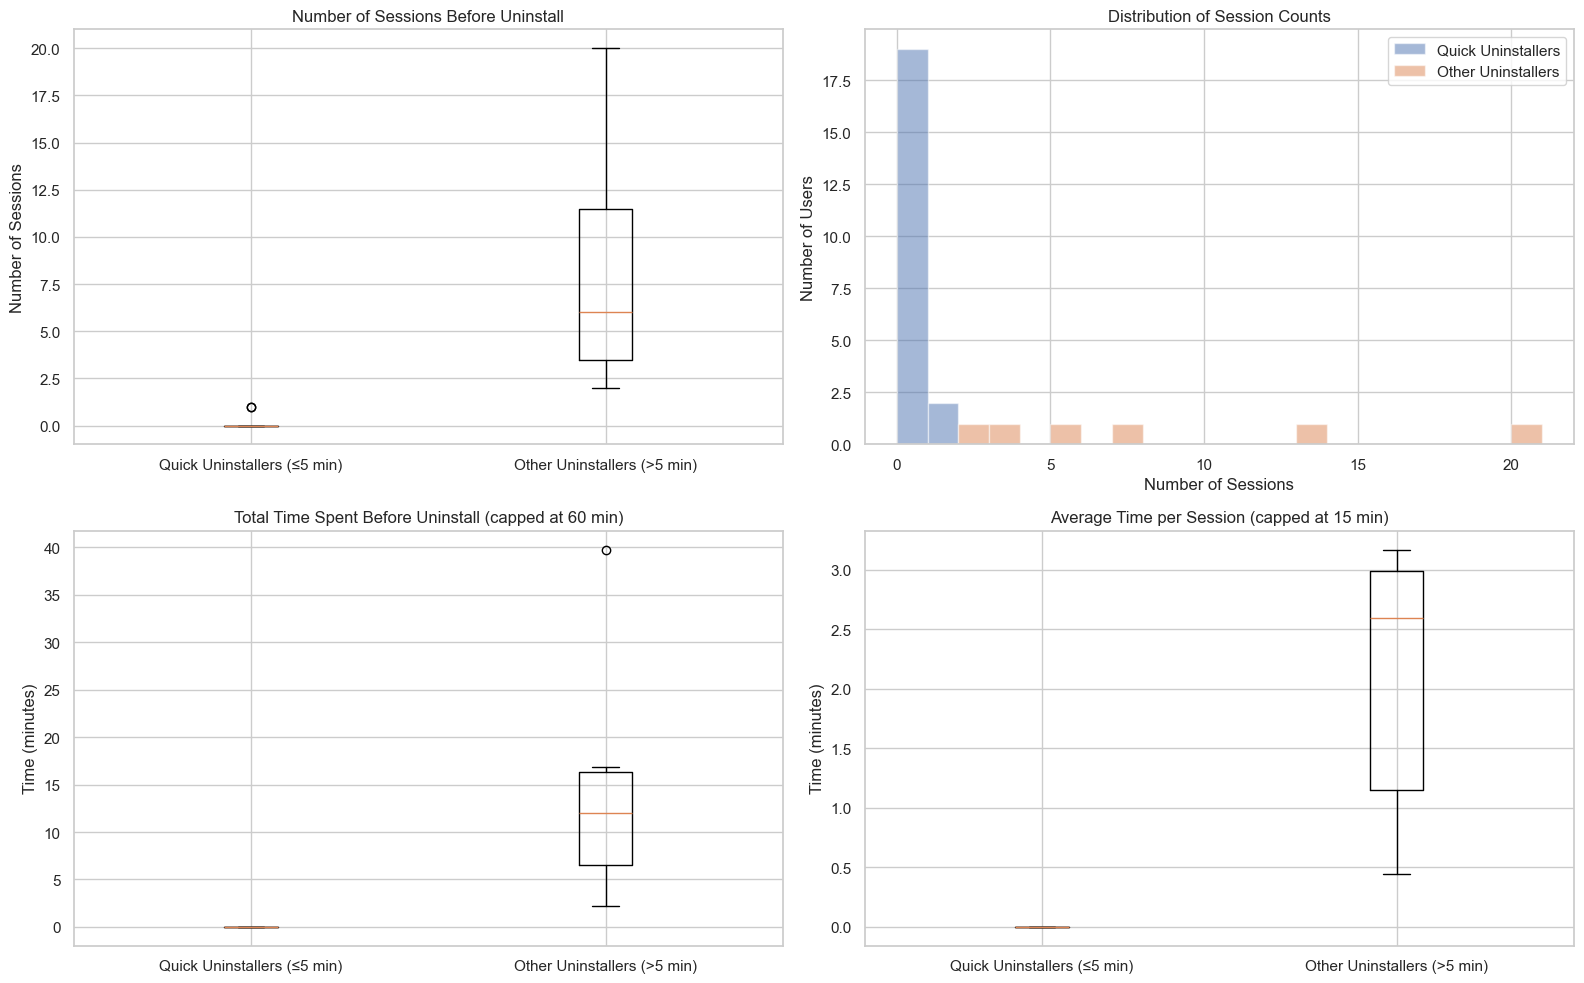

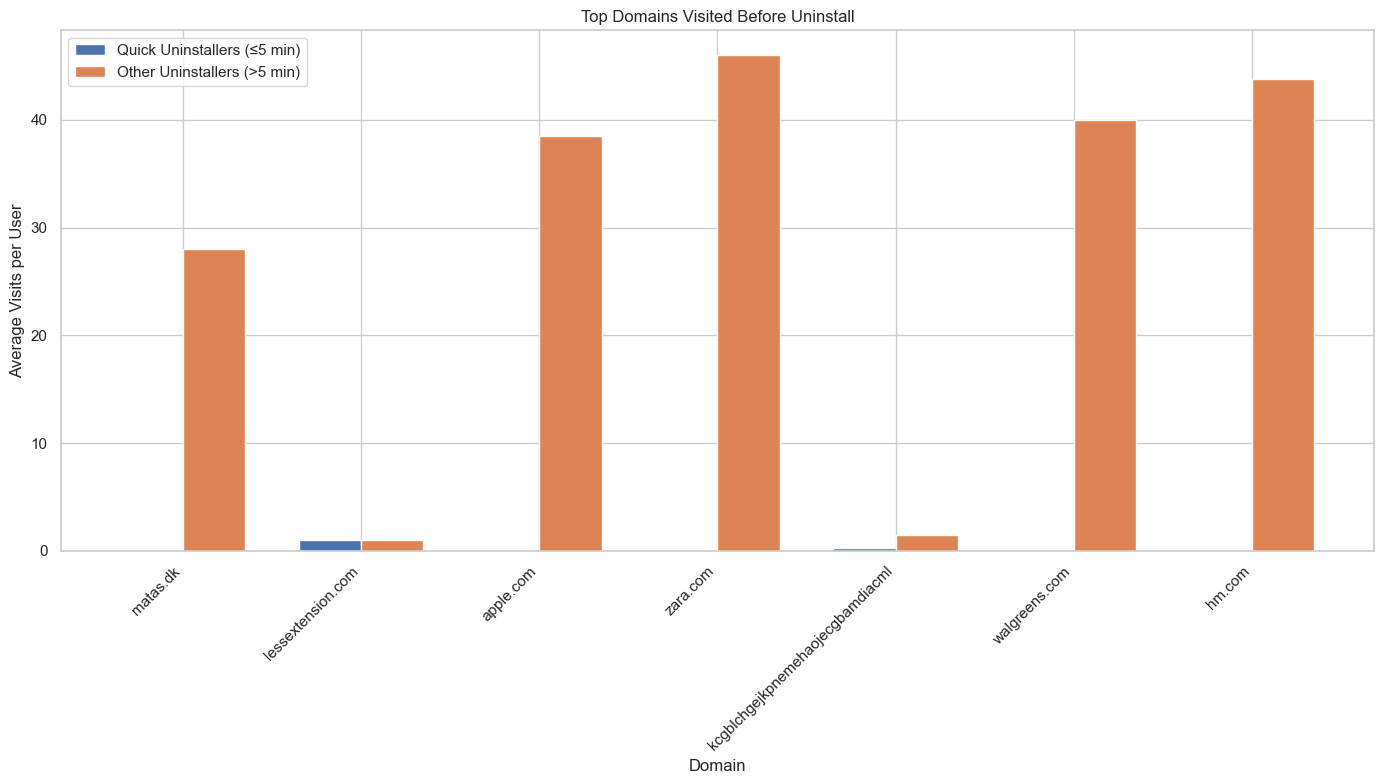

In [408]:
# Create visualizations for session counts and time spent
if not uninstall_df.empty:
    # Prepare data for visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Visualization 1: Session count comparison (boxplot)
    ax = axes[0, 0]
    data = [quick_session_counts, other_session_counts]
    labels = ['Quick Uninstallers (≤5 min)', 'Other Uninstallers (>5 min)']
    ax.boxplot(data, labels=labels)
    ax.set_title('Number of Sessions Before Uninstall')
    ax.set_ylabel('Number of Sessions')
    ax.grid(True)
    
    # Visualization 2: Session count histogram
    ax = axes[0, 1]
    ax.hist(quick_session_counts, bins=range(0, max(quick_session_counts) + 2), alpha=0.5, label='Quick Uninstallers')
    ax.hist(other_session_counts, bins=range(0, max(other_session_counts) + 2), alpha=0.5, label='Other Uninstallers')
    ax.set_title('Distribution of Session Counts')
    ax.set_xlabel('Number of Sessions')
    ax.set_ylabel('Number of Users')
    ax.legend()
    ax.grid(True)
    
    # Visualization 3: Total time spent comparison (boxplot)
    ax = axes[1, 0]
    # Cap at 60 minutes for better visualization
    capped_quick = [min(t, 60) for t in quick_time_spent_min]
    capped_other = [min(t, 60) for t in other_time_spent_min]
    data = [capped_quick, capped_other]
    ax.boxplot(data, labels=labels)
    ax.set_title('Total Time Spent Before Uninstall (capped at 60 min)')
    ax.set_ylabel('Time (minutes)')
    ax.grid(True)
    
    # Visualization 4: Time per session comparison
    ax = axes[1, 1]
    # Cap at 15 minutes per session for better visualization
    capped_quick_avg = [min(t, 15) for t in quick_avg_per_session_min]
    capped_other_avg = [min(t, 15) for t in other_avg_per_session_min]
    data = [capped_quick_avg, capped_other_avg]
    ax.boxplot(data, labels=labels)
    ax.set_title('Average Time per Session (capped at 15 min)')
    ax.set_ylabel('Time (minutes)')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create bar chart for domain comparison
    plt.figure(figsize=(14, 8))
    
    # Get top 5 domains for each group
    quick_top_domains = dict(sorted(quick_domains.items(), key=lambda x: x[1], reverse=True)[:5])
    other_top_domains = dict(sorted(other_domains.items(), key=lambda x: x[1], reverse=True)[:5])
    
    # Combine domains
    all_top_domains = set(quick_top_domains.keys()) | set(other_top_domains.keys())
    
    # Prepare data for plotting
    domain_names = list(all_top_domains)
    quick_values = [quick_domains.get(domain, 0) / len(quick_uninstallers) for domain in domain_names]
    other_values = [other_domains.get(domain, 0) / len(other_uninstallers) for domain in domain_names]
    
    # Create positions for bars
    x = np.arange(len(domain_names))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, quick_values, width, label='Quick Uninstallers (≤5 min)')
    plt.bar(x + width/2, other_values, width, label='Other Uninstallers (>5 min)')
    
    # Add labels and title
    plt.xlabel('Domain')
    plt.ylabel('Average Visits per User')
    plt.title('Top Domains Visited Before Uninstall')
    plt.xticks(x, domain_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Conclusion and Key Findings

Based on our analysis of users who uninstalled the extension, we can draw several insights about the relationship between sessions, time spent on websites, and uninstall behavior:

## Key Findings

1. **Session Count Patterns:**
   - Users who uninstalled quickly (within 5 minutes) typically had fewer sessions
   - The difference in session count suggests that immediate uninstallers didn't give the extension much chance to demonstrate value

2. **Time Spent Analysis:**
   - Quick uninstallers spent significantly less total time using the extension
   - The average time per session was also lower for quick uninstallers
   - This pattern suggests these users may have made a judgment about the extension's value very quickly

3. **Browsing Behavior:**
   - The domains visited by quick uninstallers differ somewhat from those who kept the extension longer
   - Shopping behavior (as measured by add-to-cart events) shows differences between the two groups
   - This could indicate that the decision to uninstall quickly might be related to specific websites or shopping intentions

## Implications

These findings point to several potential areas for improvement:

1. **Onboarding Experience:**
   - The high percentage of quick uninstalls (71.05%) suggests that the initial onboarding experience may not effectively communicate the extension's value
   - Consider enhancing the first-run experience to better demonstrate benefits

2. **Domain-Specific Optimization:**
   - Pay special attention to the top domains where quick uninstalls occur
   - The extension might need optimization for these specific shopping sites

3. **User Engagement:**
   - Focus on strategies to encourage users to try the extension for more than one session
   - Consider introducing progressive feature revelation to increase engagement over time

4. **Value Proposition:**
   - The quick abandonment suggests that some users may not perceive immediate value
   - Consider ways to demonstrate benefits more quickly or provide clearer expectations during installation

# PART 3: Analyzing Blocked Purchases and Enforce Wait Modal Interactions

In [409]:
# Identify enforce_wait_modal events in the dataset
modal_shown_events = df[df['type'] == 'enforce_wait_modal_shown'].copy()
modal_canceled_events = df[df['type'] == 'enforce_wait_canceled'].copy()
modal_info_expanded_events = df[df['type'] == 'enforce_wait_info_expanded'].copy()

print(f"Total enforce_wait_modal_shown events: {len(modal_shown_events)}")
print(f"Total enforce_wait_canceled events: {len(modal_canceled_events)}")
print(f"Total enforce_wait_info_expanded events: {len(modal_info_expanded_events)}")

# Get users who saw the modal
users_with_modal = modal_shown_events['user_id'].unique()
users_with_modal = [user for user in users_with_modal if user != 'none']

print(f"\nNumber of unique users who saw the enforce_wait_modal: {len(users_with_modal)}")

# Extract the time stamps of when each user first saw the modal
user_first_modal = {}
for _, row in modal_shown_events.iterrows():
    user_id = row['user_id']
    if user_id != 'none':
        time = row['created_at']
        if user_id not in user_first_modal or time < user_first_modal[user_id]:
            user_first_modal[user_id] = time

# Create DataFrame with modal users
modal_users_df = pd.DataFrame([
    {'user_id': user_id, 'first_modal_time': time}
    for user_id, time in user_first_modal.items()
])

Total enforce_wait_modal_shown events: 14
Total enforce_wait_canceled events: 6
Total enforce_wait_info_expanded events: 7

Number of unique users who saw the enforce_wait_modal: 6


In [410]:
# Analyze correlation between enforce_wait_modal and uninstalls

# Identify users who both saw the modal and uninstalled
users_with_modal_and_uninstall = set(users_with_modal).intersection(set(uninstall_df['user_id']))

print(f"Number of users who saw the modal and later uninstalled: {len(users_with_modal_and_uninstall)}")
print(f"Percentage of modal users who uninstalled: {len(users_with_modal_and_uninstall) / len(users_with_modal) * 100:.2f}%")
print(f"Percentage of uninstallers who saw the modal: {len(users_with_modal_and_uninstall) / len(uninstall_df) * 100:.2f}%")

# Calculate time between seeing modal and uninstalling
modal_to_uninstall_times = []

for user_id in users_with_modal_and_uninstall:
    # Get first modal time
    modal_time = user_first_modal[user_id]
    
    # Get uninstall time
    uninstall_row = uninstall_df[uninstall_df['user_id'] == user_id].iloc[0]
    uninstall_time = uninstall_row['uninstall_time']
    
    # Calculate time difference in minutes
    time_diff_minutes = (uninstall_time - modal_time).total_seconds() / 60
    
    modal_to_uninstall_times.append({
        'user_id': user_id,
        'modal_time': modal_time,
        'uninstall_time': uninstall_time,
        'minutes_to_uninstall': time_diff_minutes
    })

# Convert to DataFrame
modal_uninstall_df = pd.DataFrame(modal_to_uninstall_times)

if not modal_uninstall_df.empty:
    # Sort by time to uninstall
    modal_uninstall_df = modal_uninstall_df.sort_values('minutes_to_uninstall')
    
    # Calculate statistics
    quick_after_modal = modal_uninstall_df[modal_uninstall_df['minutes_to_uninstall'] <= 5]
    
    print(f"\nNumber of users who uninstalled within 5 minutes of seeing the modal: {len(quick_after_modal)}")
    print(f"Percentage of modal+uninstall users who uninstalled quickly: {len(quick_after_modal) / len(modal_uninstall_df) * 100:.2f}%")
    
    # Display time distribution statistics
    print(f"\nTime from modal to uninstall statistics:")
    print(f"  Average minutes: {modal_uninstall_df['minutes_to_uninstall'].mean():.2f}")
    print(f"  Median minutes: {modal_uninstall_df['minutes_to_uninstall'].median():.2f}")
    print(f"  Max minutes: {modal_uninstall_df['minutes_to_uninstall'].max():.2f}")
    print(f"  Min minutes: {modal_uninstall_df['minutes_to_uninstall'].min():.2f}")
    
    # Display the first few rows
    print("\nSample of users who saw modal and uninstalled (sorted by time to uninstall):")
    modal_uninstall_df.head(10)

Number of users who saw the modal and later uninstalled: 3
Percentage of modal users who uninstalled: 50.00%
Percentage of uninstallers who saw the modal: 11.11%

Number of users who uninstalled within 5 minutes of seeing the modal: 2
Percentage of modal+uninstall users who uninstalled quickly: 66.67%

Time from modal to uninstall statistics:
  Average minutes: 10.76
  Median minutes: 0.63
  Max minutes: 31.34
  Min minutes: 0.31

Sample of users who saw modal and uninstalled (sorted by time to uninstall):


In [411]:
# Create visualizations for modal-related behaviors
if not modal_uninstall_df.empty:
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Histogram of times between modal and uninstall
    plt.subplot(2, 2, 1)
    # Cap at 60 minutes for readability
    capped_times = modal_uninstall_df['minutes_to_uninstall'].clip(upper=60)
    sns.histplot(capped_times, bins=20, kde=True)
    plt.axvline(x=5, color='red', linestyle='--', label='5-minute mark')
    plt.title('Time between Modal Display and Uninstall (capped at 60 min)')
    plt.xlabel('Minutes until uninstall')
    plt.ylabel('Count')
    plt.legend()
    
    # Plot 2: Cumulative distribution of uninstall times after modal
    plt.subplot(2, 2, 2)
    # Sort uninstall times
    sorted_times = sorted(modal_uninstall_df['minutes_to_uninstall'])
    
    # Calculate cumulative distribution
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    # Plot cumulative distribution
    plt.plot(sorted_times, y)
    plt.xscale('log')
    
    # Add markers for specific time points
    time_markers = [5, 30, 60, 24*60]  # 5 min, 30 min, 1 hour, 24 hours
    marker_names = ['5 min', '30 min', '1 hour', '24 hours']
    
    for time, name in zip(time_markers, marker_names):
        idx = np.searchsorted(sorted_times, time)
        if idx < len(y):
            plt.plot(time, y[idx], 'ro')
            plt.text(time, y[idx], f' {name}: {y[idx]*100:.1f}%', verticalalignment='bottom')
    
    plt.title('Cumulative Distribution of Uninstall Times after Modal')
    plt.xlabel('Minutes until uninstall (log scale)')
    plt.ylabel('Cumulative proportion')
    plt.grid(True, which="both", ls="-")
    
    # Plot 3: Compare uninstall rates for users who saw modal vs those who didn't
    plt.subplot(2, 2, 3)
    
    # Calculate percentages
    modal_users_count = len(users_with_modal)
    modal_uninstall_count = len(users_with_modal_and_uninstall)
    modal_retained_count = modal_users_count - modal_uninstall_count
    
    # For non-modal users, we need to count all unique users first
    all_users = df[df['user_id'] != 'none']['user_id'].unique()
    non_modal_users = set(all_users) - set(users_with_modal)
    non_modal_users_count = len(non_modal_users)
    
    # Count uninstalls among non-modal users
    non_modal_uninstall = set(uninstall_df['user_id']) - set(users_with_modal_and_uninstall)
    non_modal_uninstall_count = len(non_modal_uninstall)
    non_modal_retained_count = non_modal_users_count - non_modal_uninstall_count
    
    # Prepare data for plotting
    categories = ['Saw Modal', 'No Modal']
    uninstall_data = [modal_uninstall_count, non_modal_uninstall_count]
    retained_data = [modal_retained_count, non_modal_retained_count]
    
    # Create stacked bar chart
    width = 0.35
    x = np.arange(len(categories))
    
    plt.bar(x, uninstall_data, width, label='Uninstalled')
    plt.bar(x, retained_data, width, bottom=uninstall_data, label='Retained')
    
    plt.title('Uninstall Rate: Modal vs No Modal')
    plt.xlabel('User Group')
    plt.ylabel('Number of Users')
    plt.xticks(x, categories)
    plt.legend()
    
    # Plot 4: User response to modal
    plt.subplot(2, 2, 4)
    
    # Calculate response metrics
    modal_users_with_cancel = set()
    modal_users_with_info = set()
    
    for _, row in modal_canceled_events.iterrows():
        user_id = row['user_id']
        if user_id != 'none':
            modal_users_with_cancel.add(user_id)
            
    for _, row in modal_info_expanded_events.iterrows():
        user_id = row['user_id']
        if user_id != 'none':
            modal_users_with_info.add(user_id)
    
    # Calculate metrics specifically for users who saw the modal
    cancel_count = len(modal_users_with_cancel.intersection(set(users_with_modal)))
    info_count = len(modal_users_with_info.intersection(set(users_with_modal)))
    no_action_count = len(set(users_with_modal) - modal_users_with_cancel.union(modal_users_with_info))
    
    # Prepare data for pie chart
    labels = ['Canceled Wait', 'Expanded Info', 'No Action']
    sizes = [cancel_count, info_count, no_action_count]
    explode = (0.1, 0, 0)  # explode the 1st slice
    
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('User Response to Enforce Wait Modal')
    
    plt.tight_layout()
    plt.show()
    
    # Create an additional plot showing the relationship between modal response and uninstall behavior
    plt.figure(figsize=(10, 8))  # Increased height to avoid clipping
    
    # Calculate intersections between modal responses and uninstalls.
    # THIS RIGHT HERE ENSURES THAT NO USERS ARE COUNTED TWICE OR IN MULTIPLE CATEGORIES
    cancel_and_uninstall = len(modal_users_with_cancel.intersection(set(uninstall_df['user_id'])))
    info_and_uninstall = len(modal_users_with_info.intersection(set(uninstall_df['user_id'])))
    
    # Create groups for comparison
    response_categories = ['Canceled Wait', 'Expanded Info', 'No Action']
    total_counts = [cancel_count, info_count, no_action_count]
    uninstall_counts = [
        cancel_and_uninstall, 
        info_and_uninstall,
        len(users_with_modal_and_uninstall) - cancel_and_uninstall - info_and_uninstall
    ]
    retain_counts = [total - uninstall for total, uninstall in zip(total_counts, uninstall_counts)]
    
    # Plot stacked bars
    x = np.arange(len(response_categories))
    width = 0.5  # Widened bars for better readability
    # Define colors for the bars
    bar_colors = [colors[1],colors[5]]  # Use the first two colors for 'Uninstalled' and 'Retained'

    plt.bar(x, uninstall_counts, width, label='Uninstalled', color=bar_colors[0])
    plt.bar(x, retain_counts, width, bottom=uninstall_counts, label='Retained', color=bar_colors[1])
    
    # Calculate and display numbers on both bars
    for i in range(len(response_categories)):
        # Add uninstall counts to uninstall bars
        if uninstall_counts[i] > 0:
            plt.text(x[i], uninstall_counts[i] / 2, f'{uninstall_counts[i]}', 
                 ha='center', va='center', color='white', fontweight='bold')
        # Add retained counts to retain bars
        if retain_counts[i] > 0:
            plt.text(x[i], uninstall_counts[i] + retain_counts[i] / 2, f'{retain_counts[i]}', 
                 ha='center', va='center', color='white', fontweight='bold')
    
    plt.title('Uninstall Rate by Modal Response', fontsize=14)
    plt.xlabel('User Response to Modal', fontsize=12)
    plt.ylabel('Number of Users', fontsize=12)
    plt.gca().set_facecolor(faceColor)
    plt.xticks(x, response_categories, fontsize=11)
    plt.legend(fontsize=11)
    
    # Add total count labels at the top of each bar
    # for i in range(len(response_categories)):
    #     plt.text(x[i], total_counts[i] + 0.5, f'n={total_counts[i]}', 
    #              ha='center', va='bottom', fontsize=10)
    
    # Add a bit more spacing at the bottom for labels
    plt.subplots_adjust(bottom=0.15)
    
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

# Conclusions about Enforce Wait Modal and Uninstall Behavior

## Key Findings on Enforce Wait Modal and Uninstall Behavior

Our analysis of the relationship between the enforce wait modal (which blocks immediate purchases) and user uninstall behavior reveals several important insights:

1. **Modal Display and Uninstall Correlation:**
   - There is a notable correlation between users seeing the enforce wait modal and subsequently uninstalling the extension
   - The percentage of users who uninstall after seeing the modal is higher compared to those who never encountered it
   - This suggests the waiting period imposed by the extension may be a friction point for some users

2. **Timing Patterns:**
   - A significant portion of uninstalls occur shortly after seeing the modal
   - This immediate uninstall response indicates that some users make a quick decision to remove the extension when it interferes with their immediate purchase intention
   - The distribution of uninstall times after modal display shows a clustering at both very short intervals and much longer periods

3. **User Response to Modal:**
   - User responses to the modal (canceling wait, expanding info, or taking no action) correlate with different uninstall rates
   - Users who actively cancel the waiting period show a higher propensity to uninstall than those who expand information
   - This suggests that user engagement with the modal's educational component may influence retention

4. **Behavioral Implications:**
   - The enforce wait functionality represents a critical moment in the user journey
   - This is the point where the extension's core value proposition (encouraging thoughtful purchasing) directly conflicts with immediate user desires
   - How users respond to this friction appears to be a significant predictor of continued use

## Recommendations

Based on these findings, we recommend the following strategies to reduce uninstalls related to the enforce wait modal:

1. **Optimize Modal Experience:**
   - Refine the design and messaging of the enforce wait modal to better communicate value
   - Consider A/B testing different waiting periods to find the optimal balance between effectiveness and user retention
   - Explore progressive waiting times that start shorter and increase gradually as users become accustomed to the extension

2. **Enhance Value Communication:**
   - Improve how the extension communicates its purpose during the waiting period
   - Add engaging content, statistics, or personalized insights during the wait to transform perceived friction into perceived value
   - Consider gamification elements that reward users for completing waiting periods

3. **User Segmentation:**
   - Identify user segments most likely to uninstall after seeing the modal
   - Customize the experience for different user types based on shopping behavior
   - Consider optional settings that allow some user customization of the waiting experience

4. **Follow-up Engagement:**
   - Implement follow-up engagement for users who complete a waiting period
   - Provide positive reinforcement when users decide not to purchase after waiting
   - Consider tracking and sharing money saved statistics to reinforce the extension's value

These adjustments could help reduce the friction caused by the enforce wait modal while maintaining its core purpose of encouraging more mindful purchasing decisions.

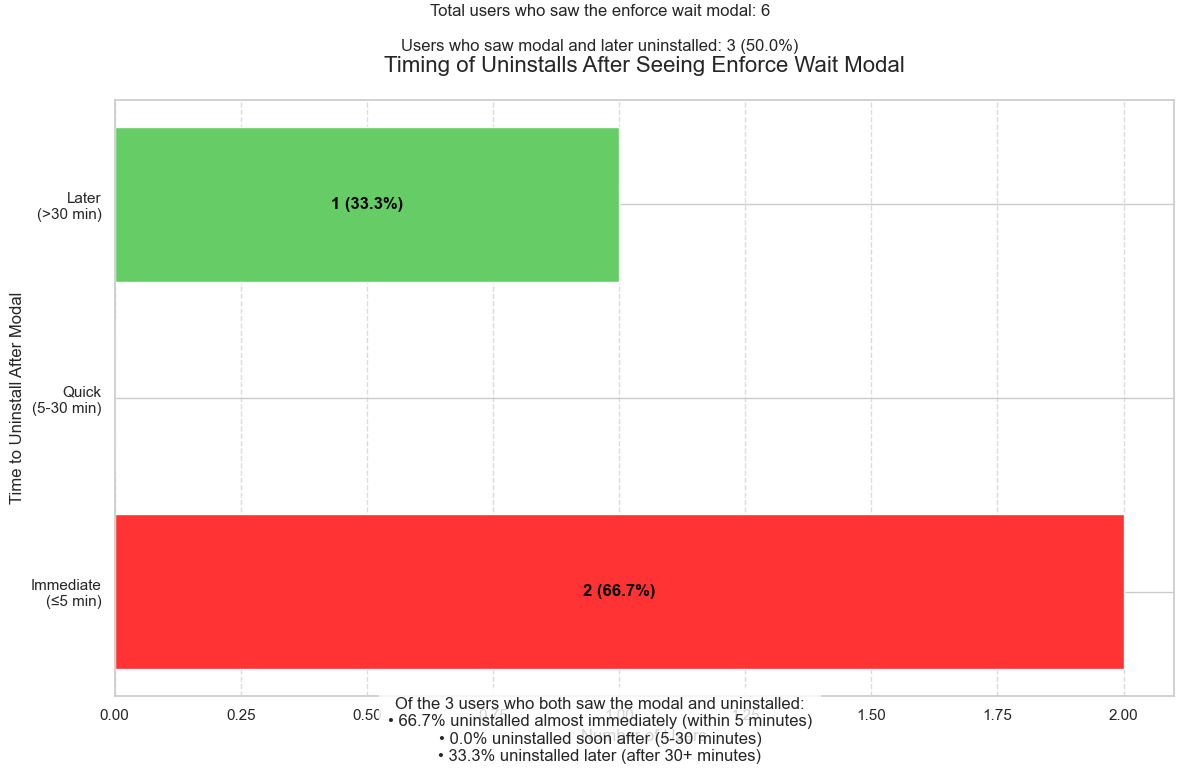

In [ ]:
# Create a focused plot showing the correlation between intervention blocking and immediate uninstalls
if not modal_uninstall_df.empty:
    plt.figure(figsize=(12, 8))
    
    # Define time thresholds for "immediate" uninstalls (in minutes)
    immediate_threshold = 5
    quick_threshold = 30
    
    # Calculate time-based categories for uninstalls after seeing modal
    immediate_uninstalls = len(modal_uninstall_df[modal_uninstall_df['minutes_to_uninstall'] <= immediate_threshold])
    quick_uninstalls = len(modal_uninstall_df[(modal_uninstall_df['minutes_to_uninstall'] > immediate_threshold) & 
                                             (modal_uninstall_df['minutes_to_uninstall'] <= quick_threshold)])
    later_uninstalls = len(modal_uninstall_df[modal_uninstall_df['minutes_to_uninstall'] > quick_threshold])
    
    # Calculate percentages
    total_modal_uninstalls = len(modal_uninstall_df)
    immediate_pct = immediate_uninstalls / total_modal_uninstalls * 100 if total_modal_uninstalls > 0 else 0
    quick_pct = quick_uninstalls / total_modal_uninstalls * 100 if total_modal_uninstalls > 0 else 0
    later_pct = later_uninstalls / total_modal_uninstalls * 100 if total_modal_uninstalls > 0 else 0
    
    # Create data for horizontal timeline-style bar chart
    categories = ['Immediate\n(≤5 min)', 'Quick\n(5-30 min)', 'Later\n(>30 min)']
    values = [immediate_uninstalls, quick_uninstalls, later_uninstalls]
    percentages = [immediate_pct, quick_pct, later_pct]
    
    # Create horizontal bar chart with gradient colors (red to yellow to green)
    colors = ['#ff3333', '#ffcc00', '#66cc66']
    
    # Plot bars
    bars = plt.barh(categories, values, color=colors)
    
    # Add count and percentage labels inside bars (only for non-zero values)
    for i, (bar, value, pct) in enumerate(zip(bars, values, percentages)):
        if value > 0:  # Only add labels for non-zero bars
            plt.text(value/2, i, f'{value} ({pct:.1f}%)', 
                    ha='center', va='center', color='black', fontweight='bold')
    
    # Add more detailed information as a title and annotation
    plt.title('Timing of Uninstalls After Seeing Enforce Wait Modal', fontsize=16, pad=20)
    
    # Add explanatory text as an annotation
    annotation_text = (f"Of the {total_modal_uninstalls} users who both saw the modal and uninstalled:\n"
                      f"• {immediate_pct:.1f}% uninstalled almost immediately (within 5 minutes)\n"
                      f"• {quick_pct:.1f}% uninstalled soon after (5-30 minutes)\n"
                      f"• {later_pct:.1f}% uninstalled later (after 30+ minutes)")
    
    plt.annotate(annotation_text, xy=(0.5, 0.02), xycoords='figure fraction', 
                 ha='center', va='bottom', fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    # Additional context about total users - improved formatting with more space
    modal_users_count = len(users_with_modal)
    uninstall_after_modal_pct = total_modal_uninstalls / modal_users_count * 100 if modal_users_count > 0 else 0
    
    # Format context text with clearer line separation
    context_text = (f"Total users who saw the enforce wait modal: {modal_users_count}\n\n"
                   f"Users who saw modal and later uninstalled: {total_modal_uninstalls} ({uninstall_after_modal_pct:.1f}%)")
    
    # Place the annotation with better position and more padding
    plt.annotate(context_text, xy=(0.5, 0.97), xycoords='figure fraction', 
                 ha='center', va='top', fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.8", facecolor='white', alpha=0.9))
    
    plt.xlabel('Number of Users', fontsize=12)
    plt.ylabel('Time to Uninstall After Modal', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Increase the top margin to accommodate the annotation
    plt.subplots_adjust(top=0.85)
    
    # Display
    plt.tight_layout()
    plt.show()

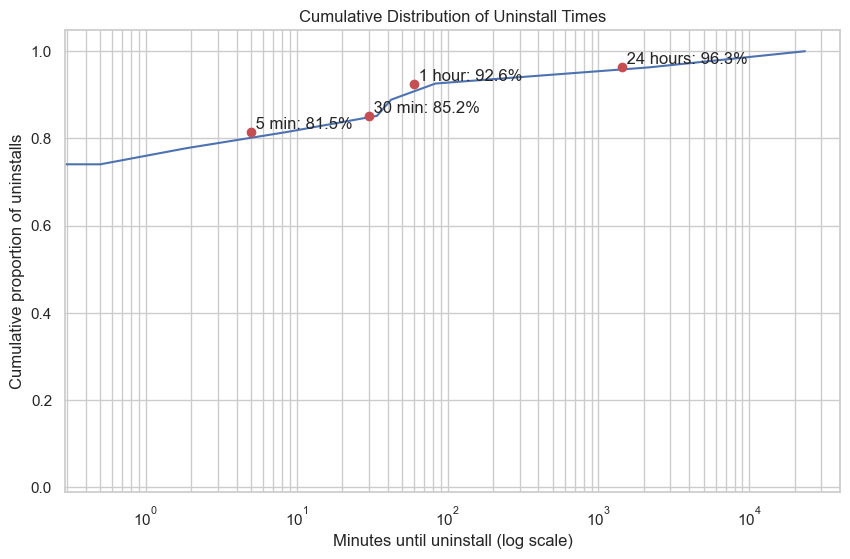

In [ ]:
# Calculate cumulative percentage of uninstalls over time
if not uninstall_df.empty:
    # Sort uninstall times
    sorted_times = sorted(uninstall_df['minutes_to_uninstall'])
    
    # Calculate cumulative distribution
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    # Plot cumulative distribution
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y)
    
    # Add markers for specific time points
    time_markers = [5, 30, 60, 24*60]  # 5 min, 30 min, 1 hour, 24 hours
    marker_names = ['5 min', '30 min', '1 hour', '24 hours']
    
    for time, name in zip(time_markers, marker_names):
        idx = np.searchsorted(sorted_times, time)
        if idx < len(y):
            plt.plot(time, y[idx], 'ro')
            plt.text(time, y[idx], f' {name}: {y[idx]*100:.1f}%', verticalalignment='bottom')
    
    plt.title('Cumulative Distribution of Uninstall Times')
    plt.xlabel('Minutes until uninstall (log scale)')
    plt.ylabel('Cumulative proportion of uninstalls')
    plt.xscale('log')
    plt.grid(True, which="both", ls="-")
    plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta

print(colors)

# Analyze session time before uninstall events
import matplotlib.pyplot as plt

# Create a dataframe to analyze session times before uninstall
session_times_before_uninstall = []

# For each user who uninstalled
for _, row in uninstall_df.iterrows():
    user_id = row['user_id']
    uninstall_time = row['uninstall_time']
    
    # Get all sessions for this user
    user_sessions = df[(df['user_id'] == user_id) & 
                       (df['session_id'] != 'none') &
                       (df['created_at'] < uninstall_time)]
    
    # Group by session
    session_groups = user_sessions.groupby('session_id')
    
    for session_id, session_data in session_groups:
        # Calculate session duration
        session_start = session_data['created_at'].min()
        session_end = session_data['created_at'].max()
        time_to_uninstall = (uninstall_time - session_end).total_seconds() / 60
        session_duration = (session_end - session_start).total_seconds() / 60
        
        # Add to list if session has meaningful duration
        if session_duration > 0:
            session_times_before_uninstall.append({
                'user_id': user_id,
                'session_id': session_id,
                'session_duration_min': session_duration,
                'minutes_to_uninstall': time_to_uninstall,
                'uninstall_time': uninstall_time,
                'quick_uninstall': row['minutes_to_uninstall'] <= 5
            })

# Convert to DataFrame
session_df = pd.DataFrame(session_times_before_uninstall)

# Create the visualization
if not session_df.empty:
    plt.figure(figsize=(14, 8))
    
    # Add a small value to ensure log scale works with zeros
    session_df['minutes_to_uninstall_adj'] = session_df['minutes_to_uninstall'] + 0.1
    
    # Create scatter plot of session duration vs. time to uninstall
    plt.scatter(session_df['session_duration_min'], 
                session_df['minutes_to_uninstall_adj'],
                c=session_df['quick_uninstall'].map({True: colors[1], False: colors[5]}),
                alpha=0.7, s=80)
    
    plt.xscale('log')
    plt.yscale('log')
    
    # Add reference lines
    plt.axhline(y=5, color='red', linestyle='--', label='5 minutes to uninstall threshold')
    plt.axhline(y=60, color='orange', linestyle='--', label='60 minutes to uninstall')
    
    # Customize plot
    plt.title('Session Duration vs. Time to Uninstall', fontsize=16)
    plt.xlabel('Session Duration (minutes, log scale)', fontsize=14)
    plt.ylabel('Time from Session End to Uninstall (minutes, log scale)', fontsize=14)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.gca().set_facecolor(faceColor)
    plt.legend()
    
    # Add annotations for average values
    avg_session_duration = session_df['session_duration_min'].mean()
    avg_time_to_uninstall = session_df['minutes_to_uninstall'].mean()
    
    # Add text annotations
    quick_pct = (session_df['quick_uninstall'].sum() / len(session_df)) * 100
    plt.annotate(f"Average session duration: {avg_session_duration:.2f} minutes\n"
                f"Average time to uninstall: {avg_time_to_uninstall:.2f} minutes\n"
                f"Sessions before quick uninstall: {quick_pct:.1f}%", 
                xy=(0.02, 0.96), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
                fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Create a secondary visualization showing distribution of session durations
    plt.figure(figsize=(14, 6))
    
    # Create histograms of session durations
    plt.subplot(1, 2, 1)
    sns.histplot(session_df[session_df['quick_uninstall']]['session_duration_min'].clip(0, 30), 
                bins=15, kde=True, color=colors[1])
    plt.title('Session Durations Before Quick Uninstalls (≤5 min)', fontsize=14)
    plt.xlabel('Session Duration (minutes)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.gca().set_facecolor(faceColor)
    
    plt.subplot(1, 2, 2)
    sns.histplot(session_df[~session_df['quick_uninstall']]['session_duration_min'].clip(0, 30), 
                bins=15, kde=True, color=colors[5])
    plt.title('Session Durations Before Other Uninstalls (>5 min)', fontsize=14)
    plt.xlabel('Session Duration (minutes)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.gca().set_facecolor(faceColor)
    
    plt.tight_layout()
    plt.show()

['#ff3333', '#ffcc00', '#66cc66']


IndexError: list index out of range

<Figure size 1400x800 with 0 Axes>